In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math


# Import Data

In [66]:
#load in training data on each potential synapse
data = pd.read_csv("./data/train/train_data.csv")
lb_data = pd.read_csv("./data/leaderboard_data.csv")

#load in additional features for each neuron
feature_weights = pd.read_csv("./data/feature_weights.csv")
morph_embeddings = pd.read_csv("./data/morph_embeddings.csv")

In [67]:
lb_data = pd.read_csv('./data/leaderboard_data.csv')

In [68]:
data[data['connected']==True]

,ID,axonal_coor_x,axonal_coor_y,axonal_coor_z,dendritic_coor_x,dendritic_coor_y,dendritic_coor_z,adp_dist,post_skeletal_distance_to_soma,pre_skeletal_distance_to_soma,...,post_brain_area,pre_nucleus_x,pre_nucleus_y,pre_nucleus_z,post_nucleus_x,post_nucleus_y,post_nucleus_z,pre_nucleus_id,post_nucleus_id,connected
109,42702,1349380,552636,757050,1349990,553979,758582,1806.240,43444.6,1163350.0,...,AL,1283392,621504,1020280,1391168,532544,775320,557121,612260,True
466,43059,1348010,550914,760809,1348340,550952,761241,177.400,51471.5,1158990.0,...,AL,1283392,621504,1020280,1400448,528000,763600,557121,612269,True
511,43104,1379150,586320,738696,1379630,586393,738956,196.147,231273.0,1068780.0,...,AL,1283392,621504,1020280,1365120,763456,812600,557121,588983,True
720,43313,1305680,503685,744954,1306880,503384,744838,870.882,40966.6,1167030.0,...,AL,1283392,621504,1020280,1325888,512192,718440,557121,583514,True
735,43328,1377520,584073,723681,1378050,583698,722852,630.880,47451.0,1084640.0,...,AL,1283392,621504,1020280,1377856,633152,736320,557121,614059,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185398,227991,1286670,613473,940317,1286440,612245,940891,1022.430,79038.7,843808.0,...,RL,1267840,625088,983200,1239424,634688,994680,557030,522733,True
185552,228145,1321720,707595,751569,1322230,707015,752639,1051.170,82945.5,436840.0,...,AL,1267840,625088,983200,1354176,771968,757040,557030,588880,True
185615,228208,1319470,470547,955017,1320300,471380,955100,738.403,78296.6,1044140.0,...,RL,1267840,625088,983200,1343808,483584,906600,557030,582613,True
185677,228270,1241420,702597,860937,1240980,700941,861744,1543.170,123877.0,859709.0,...,RL,1267840,625088,983200,1255488,657216,954560,557030,559122,True


In [69]:
data.shape

(185832, 30)

In [70]:
# join all feature_weight_i columns into a single np.array column
feature_weights["feature_weights"] = (
    feature_weights.filter(regex="feature_weight_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the feature_weight_i columns
feature_weights.drop(
    feature_weights.filter(regex="feature_weight_").columns, axis=1, inplace=True
)

# join all morph_embed_i columns into a single np.array column
morph_embeddings["morph_embeddings"] = (
    morph_embeddings.filter(regex="morph_emb_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the morph_embed_i columns
morph_embeddings.drop(
    morph_embeddings.filter(regex="morph_emb_").columns, axis=1, inplace=True
)

In [71]:
data = (
    data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

lb_data = (
    lb_data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null  float64
 12  pre_rf_x        

In [76]:
data.drop("pre_morph_embeddings", axis=1, inplace=True)

In [41]:
print("unique compartments: " + str(data["compartment"].nunique()))
print("unique pre brain areas: " + str(data["pre_brain_area"].nunique()))
print("unique post brain areas: " + str(data["post_brain_area"].nunique()))

unique compartments: 7
unique pre brain areas: 3
unique post brain areas: 3


In [42]:
#average weight and embeddings
#feature weights
data["avg_pre_feature_weights"] = data["pre_feature_weights"].map(lambda x: np.mean(x))
data["avg_post_feature_weights"] = data["post_feature_weights"].map(lambda x: np.mean(x))

#morph embeddings
data["avg_pre_morph_embeddings"] = data["pre_morph_embeddings"].map(lambda x: np.mean(x))
data["avg_post_morph_embeddings"] = data["post_morph_embeddings"].map(lambda x: np.mean(x))

data = data.drop(["pre_feature_weights", 'post_feature_weights', 'pre_morph_embeddings', 'post_morph_embeddings'], axis=1, inplace=False)

In [43]:
lb_data["avg_pre_feature_weights"] = lb_data["pre_feature_weights"].map(lambda x: np.mean(x))
lb_data["avg_post_feature_weights"] = lb_data["post_feature_weights"].map(lambda x: np.mean(x))

#morph embeddings
lb_data["avg_pre_morph_embeddings"] = lb_data["pre_morph_embeddings"].map(lambda x: np.mean(x))
lb_data["avg_post_morph_embeddings"] = lb_data["post_morph_embeddings"].map(lambda x: np.mean(x))

lb_data = lb_data.drop(["pre_feature_weights", 'post_feature_weights', 'pre_morph_embeddings', 'post_morph_embeddings'], axis=1, inplace=False)

In [77]:
#encode brain areas + compartment
#flag feature on whether pre and post brain area == or != 
data["same_brain_area"] = data[["pre_brain_area", "post_brain_area"]].apply(lambda x: 1 if x[0] == x[1] else 0, axis=1)

#one hot encode brain areas or compartment?
brain_dummies = pd.get_dummies(data[["pre_brain_area", "post_brain_area"]], drop_first=True)
data = data.drop(["pre_brain_area", "post_brain_area"], axis=1, inplace=False)
data = data.join(brain_dummies)
##

In [78]:
#encode brain areas + compartment
#flag feature on whether pre and post brain area == or != 
lb_data["same_brain_area"] = lb_data[["pre_brain_area", "post_brain_area"]].apply(lambda x: 1 if x[0] == x[1] else 0, axis=1)

#one hot encode brain areas or compartment?
brain_dummies = pd.get_dummies(lb_data[["pre_brain_area", "post_brain_area"]], drop_first=True)
lb_data = lb_data.drop(["pre_brain_area", "post_brain_area"], axis=1, inplace=False)
lb_data = lb_data.join(brain_dummies)

In [80]:
comp_dummies = pd.get_dummies(data[["compartment"]], drop_first=True)
data = data.drop(["compartment"], axis=1, inplace=False)
data = data.join(comp_dummies)

comp_dummies_lb = pd.get_dummies(lb_data[["compartment"]], drop_first=True)
lb_data = lb_data.drop(["compartment"], axis=1, inplace=False)
lb_data = lb_data.join(comp_dummies_lb)

In [81]:
data.head()

,ID,axonal_coor_x,axonal_coor_y,axonal_coor_z,dendritic_coor_x,dendritic_coor_y,dendritic_coor_z,adp_dist,post_skeletal_distance_to_soma,pre_skeletal_distance_to_soma,...,pre_brain_area_RL,pre_brain_area_V1,post_brain_area_RL,post_brain_area_V1,compartment_apical_shaft,compartment_apical_tuft,compartment_axon,compartment_basal,compartment_oblique,compartment_soma
0,42593,1187660,411978,1089020,1187390,412220,1089160,304.185,353043.0,1182170.0,...,1,0,1,0,0,0,1,0,0,0
1,42594,1204580,682542,873138,1204640,682870,873890,725.431,244156.0,914243.0,...,1,0,1,0,0,0,1,0,0,0
2,42595,1191790,403683,1093180,1188590,402414,1092660,3423.030,363829.0,1171820.0,...,1,0,1,0,0,0,1,0,0,0
3,42596,1184320,419286,1082930,1186620,419721,1085540,3442.390,344267.0,1192340.0,...,1,0,1,0,0,0,1,0,0,0
4,42597,1189150,673302,944202,1188790,677771,942901,4442.380,313630.0,788566.0,...,1,0,1,0,0,0,1,0,0,0


In [47]:
#drop compartment

data = data.drop("compartment", axis=1, inplace=False)
lb_data = lb_data.drop("compartment", axis=1, inplace=False)

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 41 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null  float64
 12  pre_rf_x        

In [83]:
#drop useless columns
#ID, pre_nucleus_id, post_nucleus_id
data = data.drop(["pre_nucleus_id", "post_nucleus_id", "pre_feature_weights", "post_feature_weights", "post_morph_embeddings", "same_brain_area"], axis=1, inplace=False)

In [ ]:
lb_data = lb_data.drop(["pre_nucleus_id", "post_nucleus_id", "pre_feature_weights", "post_feature_weights", "pre_morph_embeddings","post_morph_embeddings", "same_brain_area"], axis=1, inplace=False)

In [51]:
data["avg_pre_morph_embeddings"] = data["avg_pre_morph_embeddings"].fillna(0.0)

In [52]:
lb_data["avg_pre_morph_embeddings"] = lb_data["avg_pre_morph_embeddings"].fillna(0.0)

In [87]:
lb_data.isna().sum()

ID                                0
axonal_coor_x                     0
axonal_coor_y                     0
axonal_coor_z                     0
dendritic_coor_x                  0
dendritic_coor_y                  0
dendritic_coor_z                  0
adp_dist                          0
post_skeletal_distance_to_soma    0
pre_skeletal_distance_to_soma     0
pre_oracle                        0
pre_test_score                    0
pre_rf_x                          0
pre_rf_y                          0
post_oracle                       0
post_test_score                   0
post_rf_x                         0
post_rf_y                         0
pre_nucleus_x                     0
pre_nucleus_y                     0
pre_nucleus_z                     0
post_nucleus_x                    0
post_nucleus_y                    0
post_nucleus_z                    0
pre_brain_area_RL                 0
pre_brain_area_V1                 0
post_brain_area_RL                0
post_brain_area_V1          

# Extended feature engineering
Convert cartesian --> polar


In [137]:
def cartesian_to_r(x,y):
    return math.sqrt((x*x) + (y*y))
    
def cartesian_to_theta(x,y):
    return 1/(math.tan(y/x))
    

In [138]:
#axonal
data["axonal_r"] = data[["axonal_coor_x", "axonal_coor_y"]].apply(lambda coord: cartesian_to_r(coord[0], coord[1]), axis=1)
data["axonal_theta"] = data[["axonal_coor_x", "axonal_coor_y"]].apply(lambda coord: cartesian_to_theta(coord[0], coord[1]), axis=1)

#dendrite
data["dendritic_r"] = data[["dendritic_coor_x", "dendritic_coor_y"]].apply(lambda coord: cartesian_to_r(coord[0], coord[1]), axis=1)
data["dendritic_theta"] = data[["dendritic_coor_x", "dendritic_coor_y"]].apply(lambda coord: cartesian_to_theta(coord[0], coord[1]), axis=1)

#pre nucleus
data["pre_nucleus_r"] = data[["pre_nucleus_x", "pre_nucleus_y"]].apply(lambda coord: cartesian_to_r(coord[0], coord[1]), axis=1)
data["pre_nucleus_theta"] = data[["pre_nucleus_x", "pre_nucleus_y"]].apply(lambda coord: cartesian_to_theta(coord[0], coord[1]), axis=1)

#post nucleus
data["post_nucleus_r"] = data[["post_nucleus_x", "post_nucleus_y"]].apply(lambda coord: cartesian_to_r(coord[0], coord[1]), axis=1)
data["post_nucleus_theta"] = data[["post_nucleus_x", "post_nucleus_y"]].apply(lambda coord: cartesian_to_theta(coord[0], coord[1]), axis=1)




In [139]:
#axonal
lb_data["axonal_r"] = lb_data[["axonal_coor_x", "axonal_coor_y"]].apply(lambda coord: cartesian_to_r(coord[0], coord[1]), axis=1)
lb_data["axonal_theta"] = lb_data[["axonal_coor_x", "axonal_coor_y"]].apply(lambda coord: cartesian_to_theta(coord[0], coord[1]), axis=1)

#dendrite
lb_data["dendritic_r"] = lb_data[["dendritic_coor_x", "dendritic_coor_y"]].apply(lambda coord: cartesian_to_r(coord[0], coord[1]), axis=1)
lb_data["dendritic_theta"] = lb_data[["dendritic_coor_x", "dendritic_coor_y"]].apply(lambda coord: cartesian_to_theta(coord[0], coord[1]), axis=1)

#pre nucleus
lb_data["pre_nucleus_r"] = lb_data[["pre_nucleus_x", "pre_nucleus_y"]].apply(lambda coord: cartesian_to_r(coord[0], coord[1]), axis=1)
lb_data["pre_nucleus_theta"] = lb_data[["pre_nucleus_x", "pre_nucleus_y"]].apply(lambda coord: cartesian_to_theta(coord[0], coord[1]), axis=1)

#post nucleus
lb_data["post_nucleus_r"] = lb_data[["post_nucleus_x", "post_nucleus_y"]].apply(lambda coord: cartesian_to_r(coord[0], coord[1]), axis=1)
lb_data["post_nucleus_theta"] = lb_data[["post_nucleus_x", "post_nucleus_y"]].apply(lambda coord: cartesian_to_theta(coord[0], coord[1]), axis=1)

In [115]:
data = data.drop(["axonal_coor_x", "axonal_coor_y", "dendritic_coor_x", 'dendritic_coor_y', 'pre_nucleus_x', 'pre_nucleus_y', 'post_nucleus_x', 'post_nucleus_y'], inplace=False, axis=1)
lb_data = lb_data.drop(["axonal_coor_x", "axonal_coor_y", "dendritic_coor_x", 'dendritic_coor_y', 'pre_nucleus_x', 'pre_nucleus_y', 'post_nucleus_x', 'post_nucleus_y'], inplace=False, axis=1)

In [116]:
data.head()

,ID,axonal_coor_z,dendritic_coor_z,adp_dist,post_skeletal_distance_to_soma,pre_skeletal_distance_to_soma,pre_oracle,pre_test_score,pre_rf_x,pre_rf_y,...,avg_post_morph_embeddings,same_brain_area,axonal_r,axonal_theta,dendritic_r,dendritic_theta,pre_nucleus_r,pre_nucleus_theta,post_nucleus_r,post_nucleus_theta
0,42593,1089020,1089160,304.185,353043.0,1182170.0,0.83168,0.704509,882.724468,519.147745,...,-0.167329,1,1.257085e+06,2.766258,1.256909e+06,2.763814,1.425960e+06,1.900974,1.293850e+06,2.289111
1,42594,873138,873890,725.431,244156.0,914243.0,0.83168,0.704509,882.724468,519.147745,...,-0.167329,1,1.384513e+06,1.571799,1.384727e+06,1.570953,1.425960e+06,1.900974,1.293850e+06,2.289111
2,42595,1093180,1092660,3423.030,363829.0,1171820.0,0.83168,0.704509,882.724468,519.147745,...,-0.167329,1,1.258302e+06,2.838512,1.254864e+06,2.839923,1.425960e+06,1.900974,1.293850e+06,2.289111
3,42596,1082930,1085540,3442.390,344267.0,1192340.0,0.83168,0.704509,882.724468,519.147745,...,-0.167329,1,1.256350e+06,2.705603,1.258663e+06,2.708265,1.425960e+06,1.900974,1.293850e+06,2.289111
4,42597,944202,942901,4442.380,313630.0,788566.0,0.83168,0.704509,882.724468,519.147745,...,-0.167329,1,1.366533e+06,1.573251,1.368428e+06,1.559675,1.425960e+06,1.900974,1.293850e+06,2.289111


(array([1.3000e+01, 9.8500e+02, 2.8262e+04, 3.9863e+04, 5.4861e+04,
        3.4920e+04, 1.7043e+04, 7.7890e+03, 1.9600e+03, 1.3600e+02]),
 array([-0.94300986, -0.3922489 ,  0.15851205,  0.709273  ,  1.26003395,
         1.8107949 ,  2.36155585,  2.91231681,  3.46307776,  4.01383871,
         4.56459966]),
 <BarContainer object of 10 artists>)

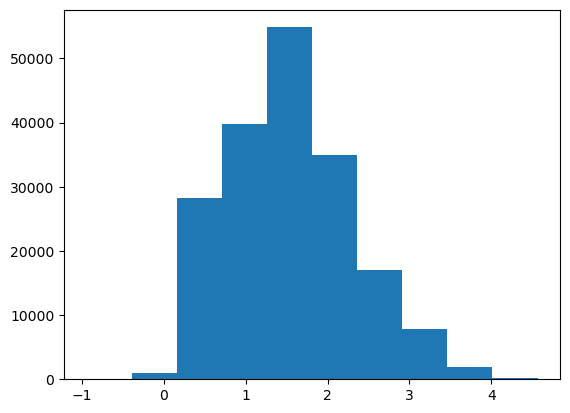

In [113]:
plt.hist(data["dendritic_theta"])

## last effort ;)
- calculate angles between axon+nucleus+dendrite for pre and post nucleus
- calculate distance between pre and post nucleus
- calculate oracle and test score differences

In [88]:
# calc angle between axonal + nucleus + dendrite for both pre and post nucleus
def calc_angle(a_x, a_y, a_z, b_x, b_y, b_z, c_x, c_y, c_z):
    a = np.array([a_x, a_y,a_z])
    b = np.array([b_x, b_y, b_z])
    c = np.array([c_x, c_y,c_z])

    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return angle
    

In [89]:
pre_points = ["axonal_coor_x", "axonal_coor_y", "axonal_coor_z", "pre_nucleus_x", "pre_nucleus_y", "pre_nucleus_z", "dendritic_coor_x", "dendritic_coor_y", "dendritic_coor_z"]
post_points = ["axonal_coor_x", "axonal_coor_y", "axonal_coor_z", "post_nucleus_x", "post_nucleus_y", "post_nucleus_z", "dendritic_coor_x", "dendritic_coor_y", "dendritic_coor_z"]

data["pre_angle"] = data[pre_points].apply(lambda coord: calc_angle(coord[0], coord[1], coord[2], coord[3], coord[4], coord[5], coord[6], coord[7], coord[8]), axis=1)
data["post_angle"] = data[post_points].apply(lambda coord: calc_angle(coord[0], coord[1], coord[2], coord[3], coord[4], coord[5], coord[6], coord[7], coord[8]), axis=1)


In [90]:
pre_points = ["axonal_coor_x", "axonal_coor_y", "axonal_coor_z", "pre_nucleus_x", "pre_nucleus_y", "pre_nucleus_z", "dendritic_coor_x", "dendritic_coor_y", "dendritic_coor_z"]
post_points = ["axonal_coor_x", "axonal_coor_y", "axonal_coor_z", "post_nucleus_x", "post_nucleus_y", "post_nucleus_z", "dendritic_coor_x", "dendritic_coor_y", "dendritic_coor_z"]

lb_data["pre_angle"] = lb_data[pre_points].apply(lambda coord: calc_angle(coord[0], coord[1], coord[2], coord[3], coord[4], coord[5], coord[6], coord[7], coord[8]), axis=1)
lb_data["post_angle"] = lb_data[post_points].apply(lambda coord: calc_angle(coord[0], coord[1], coord[2], coord[3], coord[4], coord[5], coord[6], coord[7], coord[8]), axis=1)


In [91]:
import math

In [92]:
#calc distance between pre and post nucleus
def calc_distance(a_x, a_y, a_z, b_x, b_y, b_z):
    return math.sqrt((a_x - b_x) ** 2 + (a_y - b_y) ** 2 + (a_z - b_z) ** 2)

In [97]:
def calc_distance_2d(a_x, a_y, b_x, b_y):
    return math.sqrt((a_x - b_x) ** 2 + (a_y - b_y) ** 2)

In [93]:
points = ["pre_nucleus_x", "pre_nucleus_y", "pre_nucleus_z", "post_nucleus_x", "post_nucleus_y", "post_nucleus_z"]

data["nucleus_dist"] = data[points].apply(lambda coord: calc_distance(coord[0], coord[1], coord[2], coord[3], coord[4], coord[5]), axis=1)



In [94]:
points = ["pre_nucleus_x", "pre_nucleus_y", "pre_nucleus_z", "post_nucleus_x", "post_nucleus_y", "post_nucleus_z"]

lb_data["nucleus_dist"] = lb_data[points].apply(lambda coord: calc_distance(coord[0], coord[1], coord[2], coord[3], coord[4], coord[5]), axis=1)


In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null  float64
 12  pre_rf_x        

In [96]:
data["test_score_diff"] = data[["pre_test_score", "post_test_score"]].apply(lambda x: x[1] - x[0], axis=1)

lb_data["test_score_diff"] = lb_data[["pre_test_score", "post_test_score"]].apply(lambda x: x[1] - x[0], axis=1)

data["oracle_diff"] = data[["pre_oracle", "post_oracle"]].apply(lambda x: x[1] - x[0], axis=1)

lb_data["oracle_diff"] = lb_data[["pre_oracle", "post_oracle"]].apply(lambda x: x[1] - x[0], axis=1)


In [98]:
data = data.drop(["pre_test_score", "post_test_score", "pre_oracle", "post_oracle"], axis=1, inplace=False)
lb_data = lb_data.drop(["pre_test_score", "post_test_score", "pre_oracle", "post_oracle"], axis=1, inplace=False)


In [99]:
points = ["pre_rf_x", "pre_rf_y", "post_rf_x", "post_rf_x"]

data["rf_dist"] = data[points].apply(lambda coord: calc_distance_2d(coord[0], coord[1], coord[2], coord[3]), axis=1)
lb_data["rf_dist"] = lb_data[points].apply(lambda coord: calc_distance_2d(coord[0], coord[1], coord[2], coord[3]), axis=1)



In [101]:
data = data.drop(points, axis=1, inplace=False)
lb_data = lb_data.drop(points, axis=1, inplace=False)


(array([ 4454., 15973., 33023., 41648., 40342., 29386., 14675.,  4949.,
         1205.,   177.]),
 array([-0.352145 , -0.2803902, -0.2086354, -0.1368806, -0.0651258,
         0.006629 ,  0.0783838,  0.1501386,  0.2218934,  0.2936482,
         0.365403 ]),
 <BarContainer object of 10 artists>)

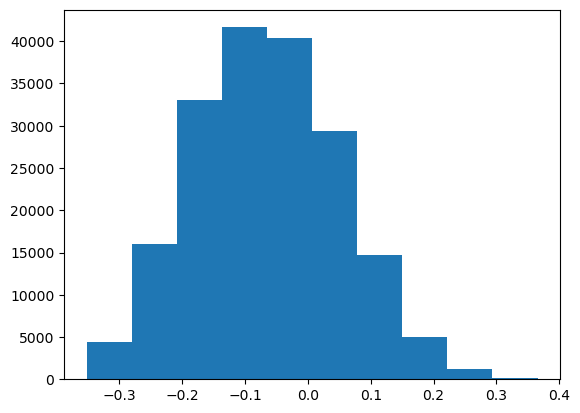

In [104]:
plt.hist(data["oracle_diff"])

In [105]:
#save data
version = 2
data.to_csv(f"./data/processed_train_data_{version}.csv", index=False)
lb_data.to_csv(f"./data/processed_leaderboard_data_{version}.csv", index=False)